# Analyzing Predictors of Covid Deaths Using Regression

## Introduction
In this study predictors of Covid-19 deaths in hospitals are analyzed using visualization and basic machine learning models. The main goal of this analysis is to identify the variables that best predict the number of covid deaths in hospitals and explain variables' predictive power as features in a decision tree model. 

A better understanding of what leads to a greater number of Covid deaths in hospitals may allow hospital systems to allocate resources and prioritize adjusting specific parameters in hospital capacity and availability of vital resources to optimize their response to future Covid outbreaks and prevent deaths from Covid in hospitals.

The primary data used in this study is a dataset from HealthData.gov called *COVID-19 Reported Patient Impact and Hospital Capacity by State Timeseries*. This dataset was chosen due to its reputable source and wide range of fields including numerical data on hospital staffing, availability of therapeutics, and hospital Covid deaths. The observations in this dataset are labeled by date and U.S. state, and the data extracted for this study range from the beginning of 2020 to the end of 2023, though the dataset is updated biweekly according to its documentation.

## Goals
- Identify the best predictors of hospital Covid deaths that pertain to hospital capacity and resource utilization
- Understand the predictive power of these variables using machine learning models
- Focus on the effects of predictors that can be potentially manipulated to decrease Covid deaths in hospitals by initiatives within the hospital system.


## Data Collection and Preprocessing
Describe the dataset(s) you're using.
Explain how the data was collected and its relevance to your project.
Discuss any preprocessing steps you've taken, such as cleaning the data, handling missing values, or transforming variables.

### Examine Dataset and Find Variables that Correlate with Covid Deaths
- There are 135 columns in this dataset.
- Identified 32 fields that have a correlation with Covid deaths of at least +/- 0.3.
- Excluded observations from year 2024 anticipating use of population data from 2020 to 2023 in analysis; population data from 2024 is not yet released by U.S. Census.

In [1]:
# Import library Pandas
import pandas as pd

# Read data from csv into Pandas dataframe
covid_data = pd.read_csv(r"C:\Users\alane\Downloads\COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW__20240125.csv")

# Display number of columns in dataframe
print("Number of columns: ", covid_data.columns.nunique())

# Display some columns of dataframe
print(covid_data.columns)

Number of columns:  135
Index(['state', 'date', 'critical_staffing_shortage_today_yes',
       'critical_staffing_shortage_today_no',
       'critical_staffing_shortage_today_not_reported',
       'critical_staffing_shortage_anticipated_within_week_yes',
       'critical_staffing_shortage_anticipated_within_week_no',
       'critical_staffing_shortage_anticipated_within_week_not_reported',
       'hospital_onset_covid', 'hospital_onset_covid_coverage',
       ...
       'previous_day_admission_pediatric_covid_confirmed_5_11',
       'previous_day_admission_pediatric_covid_confirmed_5_11_coverage',
       'previous_day_admission_pediatric_covid_confirmed_unknown',
       'previous_day_admission_pediatric_covid_confirmed_unknown_coverage',
       'staffed_icu_pediatric_patients_confirmed_covid',
       'staffed_icu_pediatric_patients_confirmed_covid_coverage',
       'staffed_pediatric_icu_bed_occupancy',
       'staffed_pediatric_icu_bed_occupancy_coverage',
       'total_staffed_pediat

#### Create 'year' Column from date 
- In order to group observations by state and year in analysis

In [2]:
# Create year col from date
covid_data['year'] = pd.to_datetime(covid_data['date']).dt.year
# Remove observations from 2024 because 2024 population data is unreleased
covid_data_exclude_2024 = covid_data[covid_data['year'].isin([2020, 2021, 2022, 2023])]
# Create list of variables that correlate with deaths_covid with a value of at least 0.3
correlated_variables = []
# Create list of correlations corresponding to important_variables
correlations = []
# Initialize correlation variable
correlation = 0
# Iterate over all columns to calculate correlation with deaths_covid and add to important_variables and correlations if meeting 0.3 correlation minimum
for col in covid_data_exclude_2024.columns:
    if col not in (['state','date', 'deaths_covid']) : # Exclude state, date and deaths_covid from iteration
        correlation = covid_data_exclude_2024[col].corr(covid_data_exclude_2024['deaths_covid'])
    if abs(correlation) >= 0.3:  # Use abs() to consider both positive and negative correlations
        correlated_variables.append(col)
        correlations.append(correlation)
# Create dictionary of important variables as keys and their correlations with deaths_covid as values
correlations_dict = {correlated_variables[i] : correlations[i] for i in range(len(correlated_variables))}
# Display list of correlated variables
print(correlated_variables)
# Display number of correlated variables identified
len(correlations_dict) # There are 32 variables with correlations at least 0.3

['critical_staffing_shortage_today_yes', 'inpatient_beds_used_covid', 'previous_day_admission_adult_covid_confirmed', 'previous_day_admission_adult_covid_suspected', 'staffed_icu_adult_patients_confirmed_and_suspected_covid', 'staffed_icu_adult_patients_confirmed_covid', 'total_adult_patients_hospitalized_confirmed_and_suspected_covid', 'total_adult_patients_hospitalized_confirmed_covid', 'total_pediatric_patients_hospitalized_confirmed_covid', 'percent_of_inpatients_with_covid', 'percent_of_inpatients_with_covid_numerator', 'percent_of_inpatients_with_covid_denominator', 'inpatient_bed_covid_utilization', 'inpatient_bed_covid_utilization_numerator', 'inpatient_bed_covid_utilization_denominator', 'adult_icu_bed_covid_utilization', 'adult_icu_bed_covid_utilization_numerator', 'previous_day_admission_adult_covid_confirmed_20-29', 'previous_day_admission_adult_covid_confirmed_30-39', 'previous_day_admission_adult_covid_confirmed_40-49', 'previous_day_admission_adult_covid_confirmed_50-59'

33

### Examine and Handle Missing Values 
- Removed correlated variables with more than 40% missing values.
- From correlated variables with low to moderate missing values, selected 7 variables that meet criteria.
- Used mean imputation to fill all missing values of selected variables as well as target variable, deaths_covid

#### Identify fields with a high percentage of missing values and select for removal
- Remove all variables that have a missing value percentage greater than 40%.

In [3]:
#
## Display a table of variables that correlat with deaths_covid with their respective number of missing values 
#

# Create list to hold correlated variables that have missing values
correlated_variables_with_missing = []
# Iterate over correlated_variables list to fill list of correlated variables with missing values
for col in correlated_variables :
    if covid_data_exclude_2024[col].isnull().any():
        correlated_variables_with_missing.append(col)
# Create series of correlated variables with corresponding number of missing values
missing_values_per_variable = covid_data_exclude_2024[correlated_variables].isnull().sum() 
# Convert series to dataframe and rename calculated column
missing_values_df = missing_values_per_variable.to_frame()
# Set the index name to be displayed as a column label
missing_values_df.index.name = 'CORRELATED VARIABLES'
# Rename the column
missing_values_df.columns = ['NUMBER OF MISSING VALUES']
# Display resulting dataframe
print("CORRELATED FIELDS WITH CORRESPONDING NUMBERS OF MISSING VALUES\n"); print(missing_values_df)

CORRELATED FIELDS WITH CORRESPONDING NUMBERS OF MISSING VALUES

                                                    NUMBER OF MISSING VALUES
CORRELATED VARIABLES                                                        
critical_staffing_shortage_today_yes                                       0
inpatient_beds_used_covid                                                419
previous_day_admission_adult_covid_confirmed                            6781
previous_day_admission_adult_covid_suspected                            7141
staffed_icu_adult_patients_confirmed_and_suspec...                      7450
staffed_icu_adult_patients_confirmed_covid                              6966
total_adult_patients_hospitalized_confirmed_and...                      6945
total_adult_patients_hospitalized_confirmed_covid                       6521
total_pediatric_patients_hospitalized_confirmed...                      7199
percent_of_inpatients_with_covid                                         697
percent_of_i

In [4]:
#
## Display a table of correlated variables categorized into high, moderate, and low percentage of missing values 
## with their respective percentage of missing values in dataset
#

# Find percentage of missing values in each column with any missing values
percentages_of_missing_values = (covid_data_exclude_2024[correlated_variables_with_missing].isnull().mean() * 100)
# Create series of columns with a high percentage of missing values (greater than 50%) with respective percentage of missing values
high_percentage_missing_values = percentages_of_missing_values[percentages_of_missing_values > 40].round(2)
# Create series of columns with a moderate percentage of missing values (b/t 10 and 40 percent) with respective percentage of missing values
mod_percentage_missing_values = percentages_of_missing_values[(percentages_of_missing_values >= 10) & (percentages_of_missing_values <= 40)].round(2)
# Create series of columns with a low percentage of missing values (less than 10%) with respective percentage of missing values
low_percentage_missing_values = percentages_of_missing_values[percentages_of_missing_values < 10].round(2)

# Create fxn to convert series_percentage_missing_values to dataframes with chosen index and column names
def series_to_frame(series, index_name, column_name):
    """Converts a Series to a DataFrame with specified index and column names."""
    df_from_series = series.to_frame()
    df_from_series.index.name = index_name
    df_from_series.columns = [column_name]
    return df_from_series

# Create dataframes from series using series_to_frame fxn
high_percentage_missing_values_df = series_to_frame(high_percentage_missing_values,'CORRELATED VARIABLES', 'PERCENTAGE OF MISSING VALUES')
mod_percentage_missing_values_df = series_to_frame(mod_percentage_missing_values,'CORRELATED VARIABLES', 'PERCENTAGE OF MISSING VALUES')
low_percentage_missing_values_df = series_to_frame(low_percentage_missing_values,'CORRELATED VARIABLES', 'PERCENTAGE OF MISSING VALUES')        
# # Display eachvariable in its category with corresponding percentages 
# print("Columns with high percentage of missing values:\n".upper() + high_percentage_missing_values_df.to_string() + "\n")
# print("Columns with moderate percentage of missing values:\n".upper() + mod_percentage_missing_values_df.to_string() + "\n")
# print("Columns with low percentage of missing values:\n".upper() + low_percentage_missing_values_df.to_string() + "\n")
# # Display each category with corresponding number of variables
# print("\nNumber of columns with missing values in each Category\n".upper())
# print("High percentage of missing values: ", high_percentage_missing_values.count())
# print("Mod percentage of missing values: ", mod_percentage_missing_values.count())
# print("Low percentage of missing values: ", low_percentage_missing_values.count())

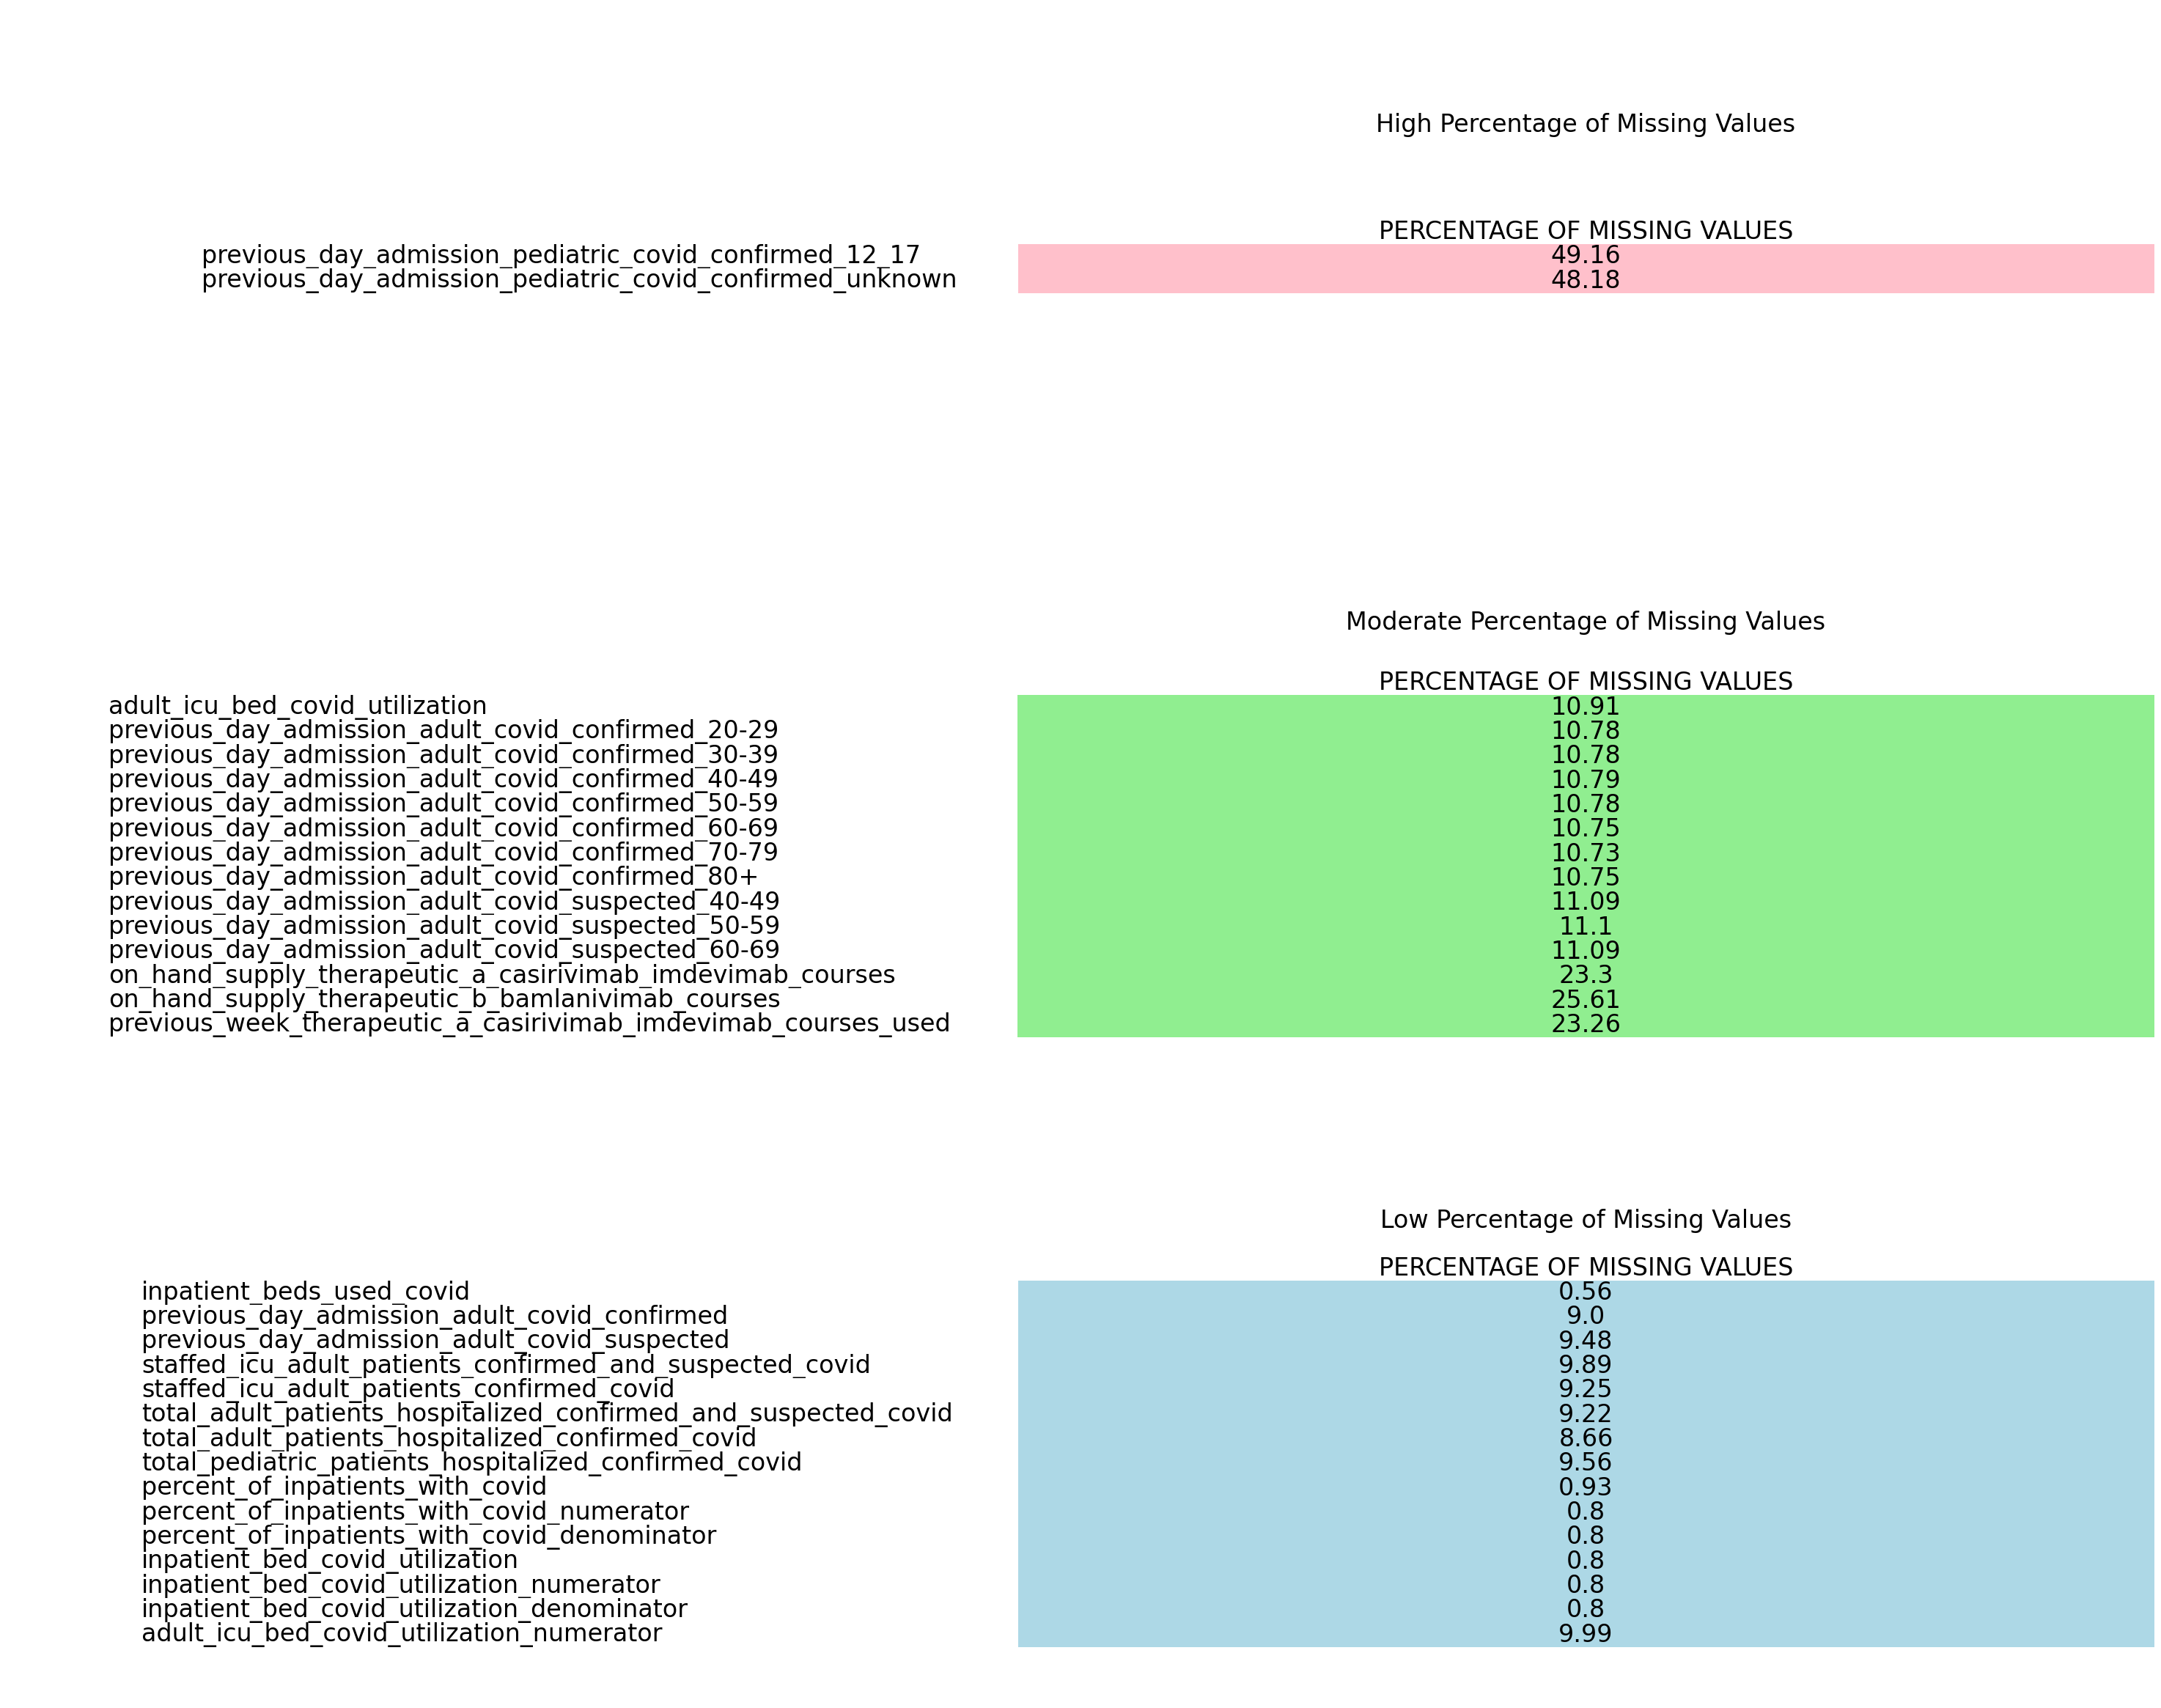

In [5]:
#
## Create colormap displaying correlated variables with repsective percentages of missing values
#

import matplotlib.pyplot as plt
import pandas as pd

def create_colormap_table(dataframes, labels, colors, filename):
    fig, axes = plt.subplots(len(dataframes), 1, figsize=(20, 10 * len(dataframes)), sharex=True)  # Adjust the figsize as needed
    plt.subplots_adjust(hspace=0.2)  # Adjust the overall vertical spacing between subplots
    
    # Plot each DataFrame as a separate subplot with different colors
    for i, (ax, df, label, color) in enumerate(zip(axes, dataframes, labels, colors)):
        ax.axis('off')
        ax.text(0.5, 0.95, label, ha='center', fontsize=24)
        table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index,
                         loc='center', cellLoc='center', cellColours=[[color]*len(df.columns)]*len(df))
        for key, cell in table.get_celld().items():
            cell.set_linewidth(0)  # Remove cell borders
        table.scale(1, 2)  # Adjust table scale to make room for labels
        table.auto_set_font_size(False)
        table.set_fontsize(24)  # Adjust font size
        
        # Decrease space between sections
        ax.set_ylim(0, 1)
        ax.set_aspect('auto')
        ax.margins(y=0.05)

    # Manually adjust the position of the first label
    axes[0].texts[0].set_position((0.5, 0.75))  # Adjust y-coordinate here

    # Save the image
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

dataframes = [high_percentage_missing_values_df, mod_percentage_missing_values_df, low_percentage_missing_values_df]
labels = ["High Percentage of Missing Values", "Moderate Percentage of Missing Values", "Low Percentage of Missing Values"]
colors = ['pink', 'lightgreen', 'lightblue']

# Create a table image with colored parts for each DataFrame
create_colormap_table(dataframes, labels, colors, 'Percentages_of_missing_values.png')




### Create list of correlated variables that have low to moderate missing values

In [6]:
#
## Create list of correlated variables with 40% missing values or less (moderate to low missing percentage missing values)
# 

# Find correlated variables with a high percentage of missing values (greater than 40%)
high_percentage_missing_vars = high_percentage_missing_values.index
# Create a new list of correlated variables with only low and moderate percentages of missing values
correlated_variables_low_mod_missing = list(set(correlated_variables) - set(high_percentage_missing_vars)) 
# Display 
print(correlated_variables_low_mod_missing)

['previous_day_admission_adult_covid_confirmed_50-59', 'previous_day_admission_adult_covid_suspected', 'staffed_icu_adult_patients_confirmed_covid', 'total_pediatric_patients_hospitalized_confirmed_covid', 'previous_day_admission_adult_covid_suspected_60-69', 'inpatient_bed_covid_utilization_denominator', 'previous_day_admission_adult_covid_confirmed_80+', 'percent_of_inpatients_with_covid', 'previous_day_admission_adult_covid_confirmed_30-39', 'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses', 'on_hand_supply_therapeutic_b_bamlanivimab_courses', 'previous_day_admission_adult_covid_confirmed_60-69', 'inpatient_beds_used_covid', 'staffed_icu_adult_patients_confirmed_and_suspected_covid', 'critical_staffing_shortage_today_yes', 'previous_day_admission_adult_covid_suspected_50-59', 'previous_day_admission_adult_covid_confirmed_70-79', 'percent_of_inpatients_with_covid_denominator', 'adult_icu_bed_covid_utilization_numerator', 'total_adult_patients_hospitalized_confirmed_and_sus

### Further Filter for Variables that Provide Actionable Insight to Help Prevent Covid Deaths in Hospitals
- Must not simply be descriptive of Covid deaths on the day of
- May provide information about resource allocation and capacity planning
- May describe metrics taken that may predict later Covid deaths in hospitals

Below are the seven selected variables with their respective justifications:
1. percent_of_inpatients_with_covid: This variable provides insights into the overall prevalence of COVID cases within the hospital, which is crucial for resource allocation, capacity planning, and understanding the burden on hospital systems.

2. total_adult_patients_hospitalized_confirmed_and_suspected_covid: Similar to the previous variable, this one offers information on the total number of adult patients hospitalized with confirmed and suspected COVID, aiding in resource planning and management.

3. previous_day_admission_adult_covid_suspected: Despite representing suspected COVID admissions from the previous day, this variable is relevant for understanding trends in hospitalizations and anticipating resource needs, contributing to proactive management strategies.

4. staffed_icu_adult_patients_confirmed_covid: ICU capacity and the number of adult patients with confirmed COVID in the ICU are critical factors in managing severe cases. This variable helps in planning and allocating ICU resources effectively, which is essential for reducing mortality rates.

5. previous_week_therapeutic_a_casirivimab_imdevimab_courses_used: This variable indicates the usage of a specific therapeutic (Casirivimab/Imdevimab), which could impact patient outcomes and inform treatment protocols. Understanding its usage can guide resource allocation and treatment strategies.

6. previous_day_admission_adult_covid_confirmed: While representing confirmed COVID admissions from the previous day, this variable provides insights into the daily influx of COVID patients, aiding in resource planning, and proactive management to prevent deaths.

7. on_hand_supply_therapeutic_b_bamlanivimab_courses: This variable represents the availability of another therapeutic (Bamlanivimab), which could influence treatment strategies and patient outcomes. Its inclusion provides additional insights into treatment options and resource allocation within hospitals.

In [7]:
#
## Create list of variablees from low/mod missing value variables that meet criteria for analysis and store
#
selected_vars = [
                      'percent_of_inpatients_with_covid', 
                      'total_adult_patients_hospitalized_confirmed_and_suspected_covid', 
                      'previous_day_admission_adult_covid_suspected', 
                      'staffed_icu_adult_patients_confirmed_covid', 
                      'previous_week_therapeutic_a_casirivimab_imdevimab_courses_used', 
                      'previous_day_admission_adult_covid_confirmed', 
                      'on_hand_supply_therapeutic_b_bamlanivimab_courses'
]
selected_vars

['percent_of_inpatients_with_covid',
 'total_adult_patients_hospitalized_confirmed_and_suspected_covid',
 'previous_day_admission_adult_covid_suspected',
 'staffed_icu_adult_patients_confirmed_covid',
 'previous_week_therapeutic_a_casirivimab_imdevimab_courses_used',
 'previous_day_admission_adult_covid_confirmed',
 'on_hand_supply_therapeutic_b_bamlanivimab_courses']

### Perform Mean Imputation to fill missing values of selected variables and target variable deaths_covid
- Included 'year' field as well 

In [8]:
#
## Do mean imputation for all missing values in correlated_variables_clean as well as deaths_covid
## because need to fill target variable(deaths_covid) as well
#
# Create list of clean correlated variables with target deaths_covid added
selected_vars_and_target_and_year = selected_vars + ['deaths_covid', 'year']

# Create df containing fields corr_vars_clean_and_targer with all missing values imputed with mean
mean_imputed_df = covid_data_exclude_2024[selected_vars_and_target_and_year].fillna(covid_data_exclude_2024[selected_vars_and_target_and_year].mean())
# Confirm successful imputation
print(True in mean_imputed_df.isna()) # No missing values found in resulting dataframe

# Copy the 'state' column from covid_data_exclude_2024 to mean_imputed_df
mean_imputed_df['state'] = covid_data_exclude_2024['state']

# Display the resulting DataFrame with the 'state' column added
mean_imputed_df


False


,percent_of_inpatients_with_covid,total_adult_patients_hospitalized_confirmed_and_suspected_covid,previous_day_admission_adult_covid_suspected,staffed_icu_adult_patients_confirmed_covid,previous_week_therapeutic_a_casirivimab_imdevimab_courses_used,previous_day_admission_adult_covid_confirmed,on_hand_supply_therapeutic_b_bamlanivimab_courses,deaths_covid,year,state
0,0.036305,60.0,11.0,7.0,12.0,3.0,18.000000,0.0,2021,HI
1,0.061377,471.0,25.0,110.0,77.0,59.0,3864.000000,2.0,2021,MN
2,0.050505,810.0,132.0,236.0,36.0,89.0,1982.000000,19.0,2021,NC
3,0.053548,119.0,0.0,18.0,0.0,6.0,100.000000,2.0,2021,RI
4,0.040530,106.0,4.0,30.0,34.0,7.0,1481.000000,1.0,2021,NE
...,...,...,...,...,...,...,...,...,...,...
76416,0.024757,356.0,36.0,40.0,3.0,37.0,0.000000,0.0,2023,NJ
76417,0.077711,1268.0,207.0,73.0,0.0,62.0,0.000000,13.0,2023,NC
76418,0.033841,20.0,5.0,2.0,0.0,2.0,894.178386,0.0,2023,WY
76419,0.043717,568.0,73.0,44.0,0.0,109.0,894.178386,0.0,2023,MA


## Exploratory Data Analysis
- Identified 5 states with the greatest Covid deaths in hospitals per capita on average from 2020 to 2023: Arizona, Iowa, Minnesota, New York, and Oregon.
- Visualized correlations of selected variables with deaths_covid in heat map.
- Calculated aggregate score of selected variables for each state from 2020 to 2023 and compared to deaths per capita in visualization:
  - Only two of the states with the greatest Covid deaths in hospitals per capita on average from 2020 to 2023 also had the greatest aggregate scores: Arizona and New York.
  - Since aggregate scores were calculated simply by averaging each field's value adjusted by population, and then summming together for each state, these results suggest that some of the selected variables are significantly more important than others in predicting deaths and there may be contingencies: a variable is more predictive if a certain threshold is reached in another field; A decision tree might be appropriate to further analyze how predictive each variable is.A.

### Visualize States with Greatest Average Per Capita Reported Covid Deaths from 2020 to 2023
- Find the states with the highest average per capita over years 2020 to 2023
- Merged dataframes covid_data with census population data
  - Also merge with state codes in order to merge with population data successfully due to discrepancy is state labels
- Results: New York, Oregon, Arizona, Iowa, and Minnesota had the greatest per capita reported Covid deaths form 2020 to 2023.

In [9]:
#
## Create dataframe of state codes with their respective populations for years 2020 through 2023
## in order to later merge with covid_data dataset for per capita calculations
#

# Read in census data 
census_data = pd.read_csv(r"C:\Users\alane\Downloads\NST-EST2023-ALLDATA.csv")
# Create list of columns with state and populations 
desired_cols = ['NAME', 'POPESTIMATE2020','POPESTIMATE2021','POPESTIMATE2022','POPESTIMATE2023']
# Create subset with desired columns
pop_data = census_data[desired_cols]
# Get rid of regions (only want states) not included in covid_data dataset
pop_data = census_data[desired_cols][14:] # Regions end on index 14
# Read dataset of states with their respective codes into df
state_codes = pd.read_csv(r"C:\Users\alane\Downloads\table-data.csv")
# Only keep state and code
state_codes = state_codes[['state','code']]
# Left join pop_data, state_codes in order to create pop_data with codes
pop_data_codes = pop_data.merge(state_codes, left_on = 'NAME', right_on = 'state', how='left')
# Puerto Rico was included in both pop_data and deaths data, but not state_codes, so need to manually enter PR code
pop_data_codes.loc[pop_data_codes['NAME'] == 'Puerto Rico', 'code'] = 'PR'
# Simplify pop_data_codes
desired_cols = ['code', 'POPESTIMATE2020','POPESTIMATE2021','POPESTIMATE2022','POPESTIMATE2023']
pop_data_codes = pop_data_codes[desired_cols]
pop_data_codes.head()

,code,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,POPESTIMATE2023
0,AL,5031864,5050380,5073903,5108468
1,AK,732964,734923,733276,733406
2,AZ,7186683,7272487,7365684,7431344
3,AR,3014348,3028443,3046404,3067732
4,CA,39503200,39145060,39040616,38965193


In [10]:
#
## Create calculation of Covid deaths per capita for each state, year in dataframe
#

# Group covid data by state and year and calculate total covid deaths per state and year
total_deaths_by_state_year = covid_data_exclude_2024.groupby(['state','year']).agg({'deaths_covid' : 'sum'})
# Keep calculation but reset index in order to perform merge without losing year
total_deaths_by_state_year = total_deaths_by_state_year.reset_index()
# Perform right merge to pop_data_codes in order to put population estimates in dataframe
total_deaths_by_state_year = total_deaths_by_state_year.merge(pop_data_codes, how = 'right', left_on = 'state', right_on = 'code')

# Now make per capita col
for index, row in total_deaths_by_state_year.iterrows() :
    if row['year'] == 2020:
        total_deaths_by_state_year['deaths_per_cap'] = total_deaths_by_state_year['deaths_covid'] / total_deaths_by_state_year['POPESTIMATE2020']
    elif row['year'] == 2021: 
        total_deaths_by_state_year['deaths_per_cap'] = total_deaths_by_state_year['deaths_covid'] / total_deaths_by_state_year['POPESTIMATE2021']
    elif row['year'] == 2022: 
        total_deaths_by_state_year['deaths_per_cap'] = total_deaths_by_state_year['deaths_covid'] / total_deaths_by_state_year['POPESTIMATE2022']
    elif row['year'] == 2023: 
        total_deaths_by_state_year['deaths_per_cap'] = total_deaths_by_state_year['deaths_covid'] / total_deaths_by_state_year['POPESTIMATE2023']

total_deaths_by_state_year.head()

,state,year,deaths_covid,code,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,POPESTIMATE2023,deaths_per_cap
0,AL,2020,3955.0,AL,5031864,5050380,5073903,5108468,0.000774
1,AL,2021,6390.0,AL,5031864,5050380,5073903,5108468,0.001251
2,AL,2022,2184.0,AL,5031864,5050380,5073903,5108468,0.000428
3,AL,2023,394.0,AL,5031864,5050380,5073903,5108468,0.000077
4,AK,2020,200.0,AK,732964,734923,733276,733406,0.000273


<Figure size 640x480 with 0 Axes>

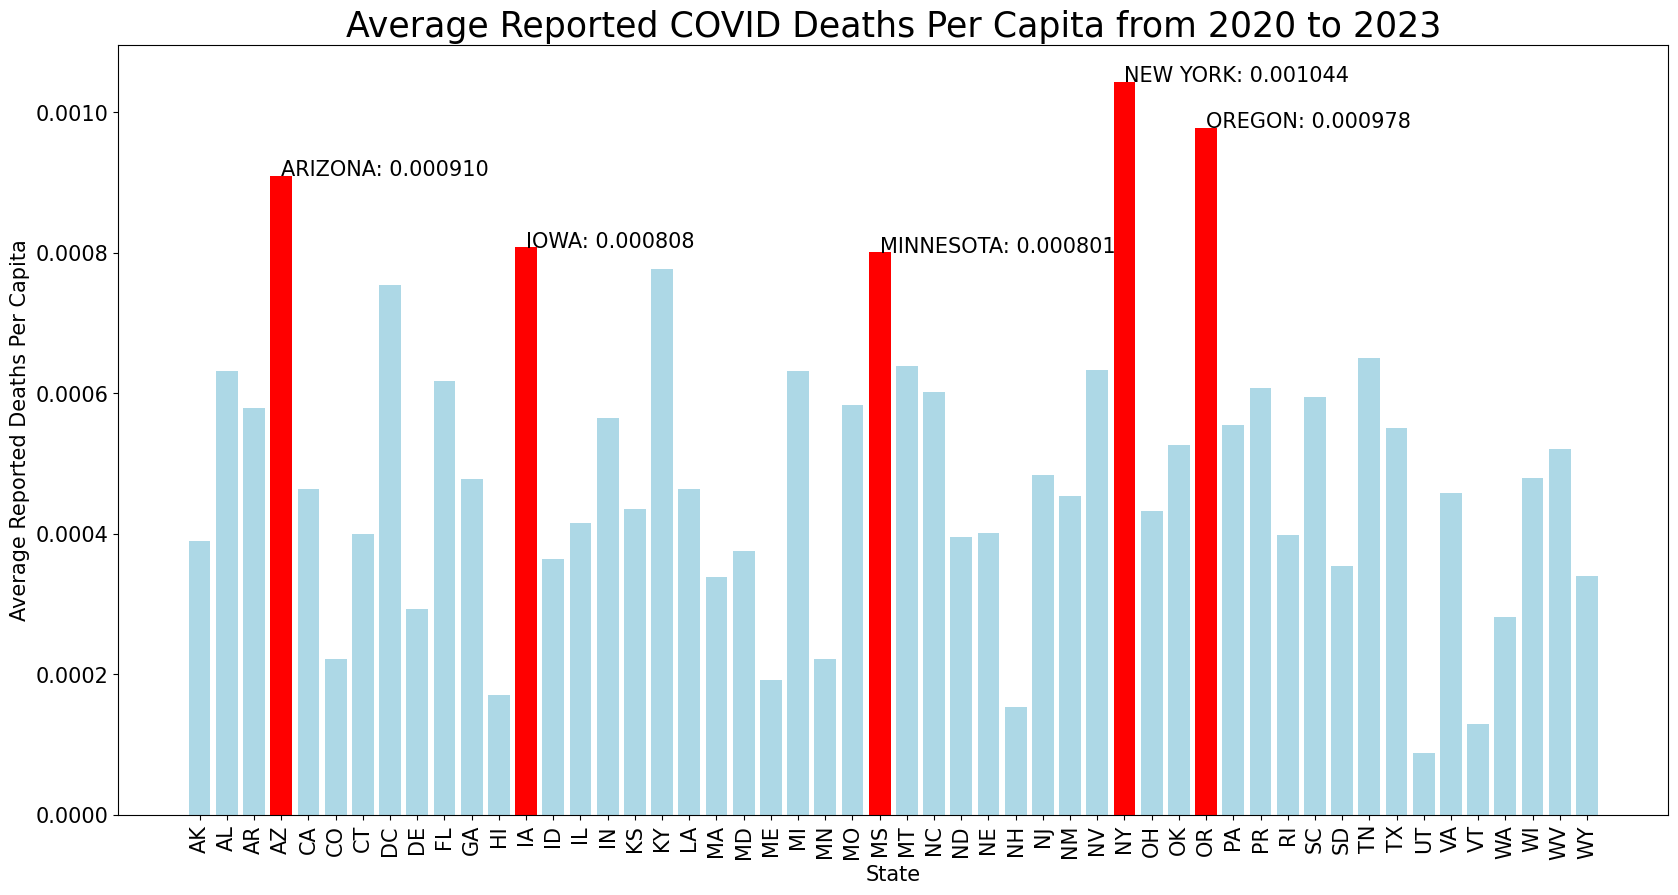

       deaths_per_cap
state                
NY           0.001044
OR           0.000978
AZ           0.000910
IA           0.000808
MS           0.000801


In [11]:
#
## Plot deaths_per_capita averaged over 2020 to 2023 for each state
#

# Create datframe with average deaths per capita over 2020-2023 by state 
average_deaths_per_cap = total_deaths_by_state_year.groupby('state').agg({'deaths_per_cap' : 'mean'})
# Create dataframe with only top 5 highest average deaths per cap over 2020-2023 by state
highest_average_deaths_per_cap = average_deaths_per_cap.sort_values(by = 'deaths_per_cap', ascending = False)[:5]
import matplotlib.pyplot as plt
plt.clf()
# Create bars for average_deaths_per_cap and top 5 highest
plt.figure(figsize=(20,10))
plt.bar(average_deaths_per_cap.index, average_deaths_per_cap['deaths_per_cap'], color='lightblue')  
plt.bar(highest_average_deaths_per_cap.index, highest_average_deaths_per_cap['deaths_per_cap'], color='red')  

# Customize plot
plt.xlabel('State', fontsize = 15)
plt.ylabel('Average Reported Deaths Per Capita', fontsize = 15)
plt.title('Average Reported COVID Deaths Per Capita from 2020 to 2023', fontsize = 25)
plt.xticks(rotation=90, fontsize = 15) # Rotate state labels for better readability
plt.yticks(fontsize = 15) 

# Superimpose plot of states with top 5 highest deaths per capita from 2020 to 2023
plt.text("AZ", highest_average_deaths_per_cap.loc['AZ','deaths_per_cap'],"ARIZONA: %.6f" %highest_average_deaths_per_cap.loc['AZ','deaths_per_cap'], fontsize = 15)
plt.text("IA", highest_average_deaths_per_cap.loc['IA','deaths_per_cap'],"IOWA: %.6f" %highest_average_deaths_per_cap.loc['IA','deaths_per_cap'], fontsize = 15)
plt.text("MS", highest_average_deaths_per_cap.loc['MS','deaths_per_cap'],"MINNESOTA: %.6f" %highest_average_deaths_per_cap.loc['MS','deaths_per_cap'], fontsize = 15)
plt.text("NY", highest_average_deaths_per_cap.loc['NY','deaths_per_cap'],"NEW YORK: %.6f" %highest_average_deaths_per_cap.loc['NY','deaths_per_cap'], fontsize = 15)
plt.text("OR", highest_average_deaths_per_cap.loc['OR','deaths_per_cap'],"OREGON: %.6f" %highest_average_deaths_per_cap.loc['OR','deaths_per_cap'], fontsize = 15)


# Save and show plot
plt.savefig('Average_reported_COVID_deaths_per_capita.png', bbox_inches='tight', pad_inches=0.1)
plt.show()
print(highest_average_deaths_per_cap)

### Visualize Correlation of Selected Variables

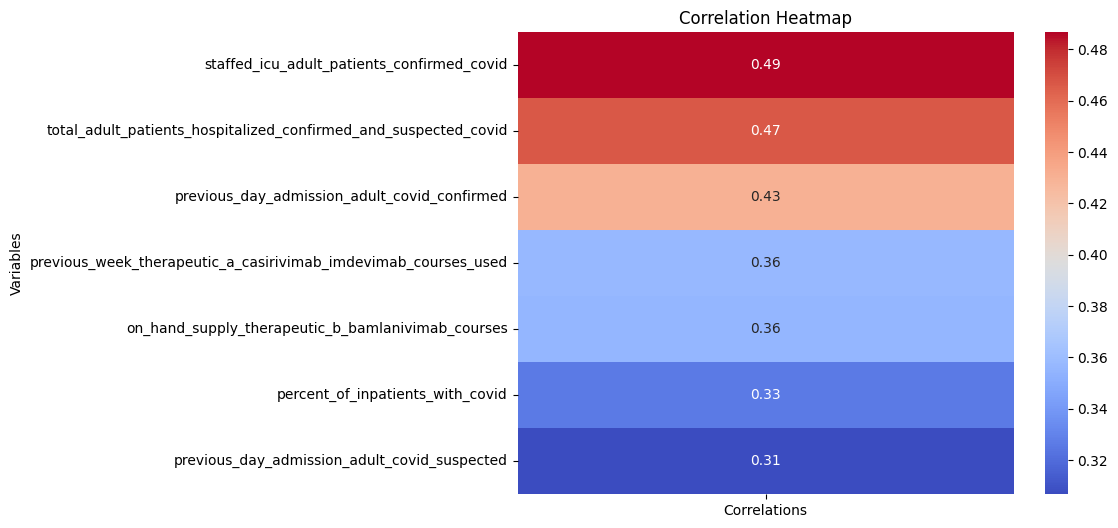

In [12]:
#
## Plot selected variables with respective correlations with deaths_covid in a heatmap
#

# Retrieve correlations of selected variables from correlations dict
selected_pairs = {key: value for key, value in correlations_dict.items() if key in selected_vars}
selected_pairs_sorted = dict(sorted(selected_pairs.items(), key = lambda item: item[1], reverse =True))
selected_vars_sorted = list(selected_pairs_sorted.keys())
correlations_sorted = list(selected_pairs_sorted.values())

# Import seaborn for heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Create a correlation matrix for the selected variables
correlation_df = pd.DataFrame.from_dict(selected_pairs_sorted, orient = 'index', columns = ['Correlations'])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.ylabel('Variables')
plt.savefig('correlation_map.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

### Connect Correlated Variables to Average Deaths Per Capita By State
- Calculate aggregate scores using values of selected variables and their correlations to see how they relate to average deaths per capita
  - Only two of the states in the top five highest Covid deaths per capita are also in the top five with calculated aggregate scores for the selected variables (Arizona and New York)
  - The aggregate scores and the deaths per cap do not align well; it appears that the totality of the selected variables and their correlations do not fully capture the complex contributions of the variables to Covid death rates.

In [13]:
#
## Calculate weighted aggregate scores of correlated variables averaged from 2020 to 2023
#
# Merge year and state fields only imputed dataframe
imputed_with_populations_df = pd.merge(mean_imputed_df, total_deaths_by_state_year, on = ['year', 'state'])

def calculate_weighted_aggregate_score(df, correlations_dict, selected_vars):
    """@param df dataframe holding values for selected variables and population estimates"""
    """@param correlations_dict dictionary containing variables(keys) and correlations(values)"""
    """@param selected_vars list of variables to be calculated on"""
    """@return aggregate_score series of weighted scores for each observation aggregated over all selected variables"""
    selected_correlations = {var: correlations_dict[var] for var in selected_vars if var in correlations_dict}
    # Calculate weighted scores for each selected variable
    weighted_scores = pd.DataFrame()
    for var in selected_vars:
        if var in selected_correlations:
            weighted_scores[var] = df[var] * selected_correlations[var]
    
    # Calculate aggregate score by summing across selected variables
    aggregate_score = weighted_scores.sum(axis=1)
    return aggregate_score

# Calculate weighted aggregate score using calculate_weighted_aggregate_score function
aggregate_score = calculate_weighted_aggregate_score(imputed_with_populations_df, correlations_dict, selected_vars)

def adjust_score_for_population(weighted_aggregate_score, df):
    """@param weighted_aggregate_score series of weighted scores for each observation aggregated over all selected variables"""
    """@param df dataframe holding values for selected variables and population estimates"""
    """@return adjusted score series of weighted_aggregate scores adjusted for population of state,year"""
    adjusted_score = weighted_aggregate_score.copy()  # Make a copy of the weighted aggregate score
    
    for i, row in df.iterrows():
        for var in selected_vars:
            if var != 'percent_of_inpatients_with_covid':
                population_estimate_col = f"POPESTIMATE{row['year']}"
                population_estimate = row[population_estimate_col]
                
                # Adjust aggregate score for population (avoid division by zero)
                adjusted_score[i] = weighted_aggregate_score[i] / max(population_estimate, 1)
    
    return adjusted_score
# Calculate population-adjusted aggregate score for each state,year
adjusted_aggregate_score = adjust_score_for_population(aggregate_score, imputed_with_populations_df)
# Add adjusted_aggregate_scores to imputed_with_populations_df
result_df = pd.concat([imputed_with_populations_df, adjusted_aggregate_score.rename('adjusted_aggregate_score')], axis=1)

# Group by state and calculate the average adjusted aggregate score from 2020 to 2023
average_adjusted_aggregate_score = result_df.groupby('state')['adjusted_aggregate_score'].mean()

# Convert Series to DataFrame and reset index
average_adjusted_aggregate_score_df = average_adjusted_aggregate_score.reset_index()

# Rename columns
average_adjusted_aggregate_score_df.columns = ['state', 'average_adjusted_aggregate_score']

# Display the DataFrame
highest_aggregate_scores = average_adjusted_aggregate_score_df.sort_values(by='average_adjusted_aggregate_score', ascending=False)[:5]
highest_aggregate_scores

,state,average_adjusted_aggregate_score
51,WY,0.000557
7,DC,0.000383
47,VT,0.000357
28,ND,0.000333
26,MT,0.000324


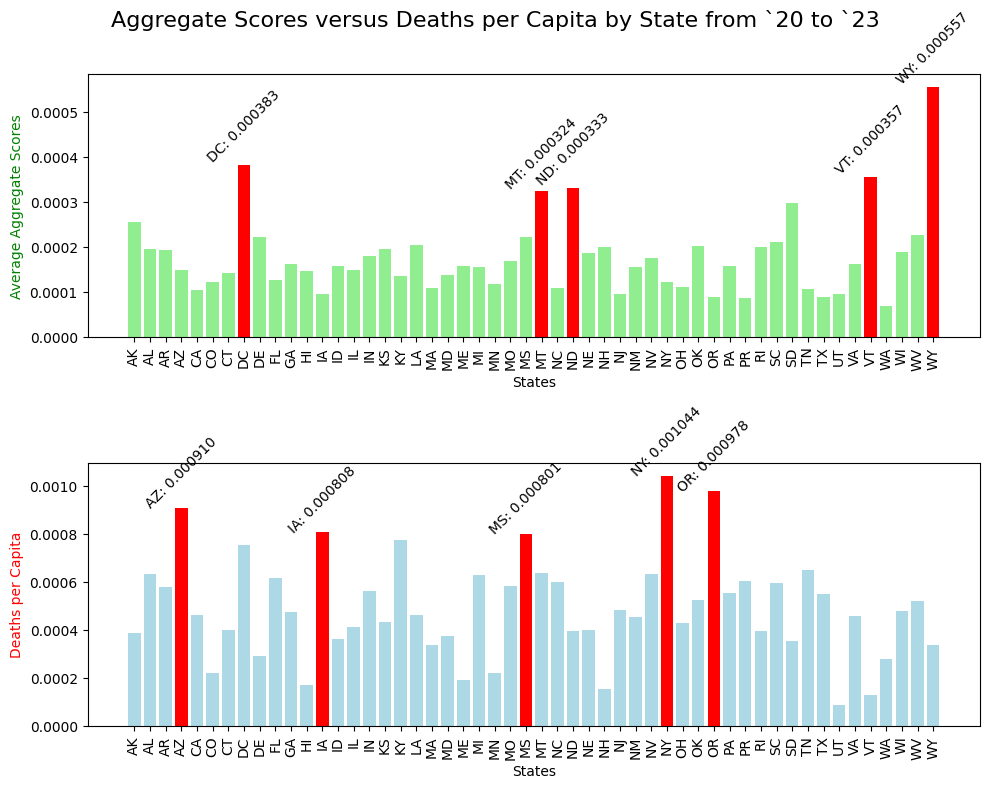

In [14]:
#
## Compare plot of average aggregated adjusted scores for each state to plot of average covid deaths in hospitals by state
#
import matplotlib.pyplot as plt
# Create a figure and axis object with two subplots (vertically stacked)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

# Set state labels for both subplots
state_labels = average_adjusted_aggregate_score_df.state

# Plot aggregate scores 
highest_aggregate_scores = average_adjusted_aggregate_score_df.sort_values(by='average_adjusted_aggregate_score', ascending=False)[:5]
ax1.bar(range(len(average_adjusted_aggregate_score_df)), average_adjusted_aggregate_score_df['average_adjusted_aggregate_score'], color='lightgreen')
ax1.bar(highest_aggregate_scores.index, highest_aggregate_scores['average_adjusted_aggregate_score'], color='red')
ax1.set_ylabel('Average Aggregate Scores', color='green')
ax1.set_xlabel('States')
ax1.set_xticks(range(len(state_labels)))
ax1.set_xticklabels(state_labels, rotation = 90)

# Add labels to the highest aggregate score bars
for state, score in highest_aggregate_scores.iterrows():
    ax1.text(state, score['average_adjusted_aggregate_score'], f"{score['state']}: {score['average_adjusted_aggregate_score']:.6f}", fontsize=10, ha='center', va='bottom', rotation = 45)

# Plot deaths per capita again
ax2.set_xticks(range(len(state_labels)))
ax2.set_xticklabels(state_labels, rotation=90)
ax2.bar(average_deaths_per_cap.index, average_deaths_per_cap['deaths_per_cap'], color='lightblue')  
ax2.bar(highest_average_deaths_per_cap.index, highest_average_deaths_per_cap['deaths_per_cap'], color='red')  
ax2.set_ylabel('Deaths per Capita', color='red')
ax2.set_xlabel('States')
# Add labels to the highest deaths per capita bars
for state, deaths in highest_average_deaths_per_cap.iterrows():
    ax2.text(state, deaths['deaths_per_cap'], f"{state}: {deaths['deaths_per_cap']:.6f}", fontsize=10, ha='center', rotation = 45)


# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
# Add a shared title
plt.suptitle('Aggregate Scores versus Deaths per Capita by State from `20 to `23', fontsize=16)
# Show the plot
plt.savefig('Aggregate_scores_vs_deaths_per_cap.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


## Modeling
- A decision tree was used first to create a model predictive of deaths from covid in hosptials from imputed selected variables. The decision tree is appropriate for this model because the aggregate scores of the correlated variables did not align well with the greatest number of covid deaths, suggesting that there may be more predictive power in the interactions between variables than in the correlations of the variables alone.

### Split Data and Try Decision Tree with Selected Variables
- results in MAE of about 6.6
- percent error (based off range) 0.29 %

In [15]:
# split mean_imputed data
X = mean_imputed_df[selected_vars]
y = mean_imputed_df.deaths_covid

from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [16]:
# Create decision tree model
from sklearn.tree import DecisionTreeRegressor
covid_model = DecisionTreeRegressor(max_depth = 4, random_state = 0)
covid_model.fit(train_X, train_y)

DecisionTreeRegressor(max_depth=4, random_state=0)

In [17]:
# Generate predictions 
val_predictions = covid_model.predict(val_X)
# Inspect predictions and actual values from validation data
print("Predictions from val data:");print(val_predictions[:5])
print("Actual values from val data:");print(val_y.head())

Predictions from val data:
[33.59064994  2.15209968  8.37454948  2.15209968  8.37454948]
Actual values from val data:
46406    26.0
37822     0.0
16703    32.0
46483     0.0
4239      1.0
Name: deaths_covid, dtype: float64


In [18]:
# Calculate mean absolute error
from sklearn.metrics import mean_absolute_error
print("MAE: ", mean_absolute_error(val_y, val_predictions))

MAE:  6.573693129696528


In [19]:
# calculate percent error of predictions
percent_error = mean_absolute_error(val_y, val_predictions) / (mean_imputed_df['deaths_covid'].max() - mean_imputed_df['deaths_covid'].min()) * 100
print("Percent error: ", percent_error)

Percent error:  0.2920343460549324


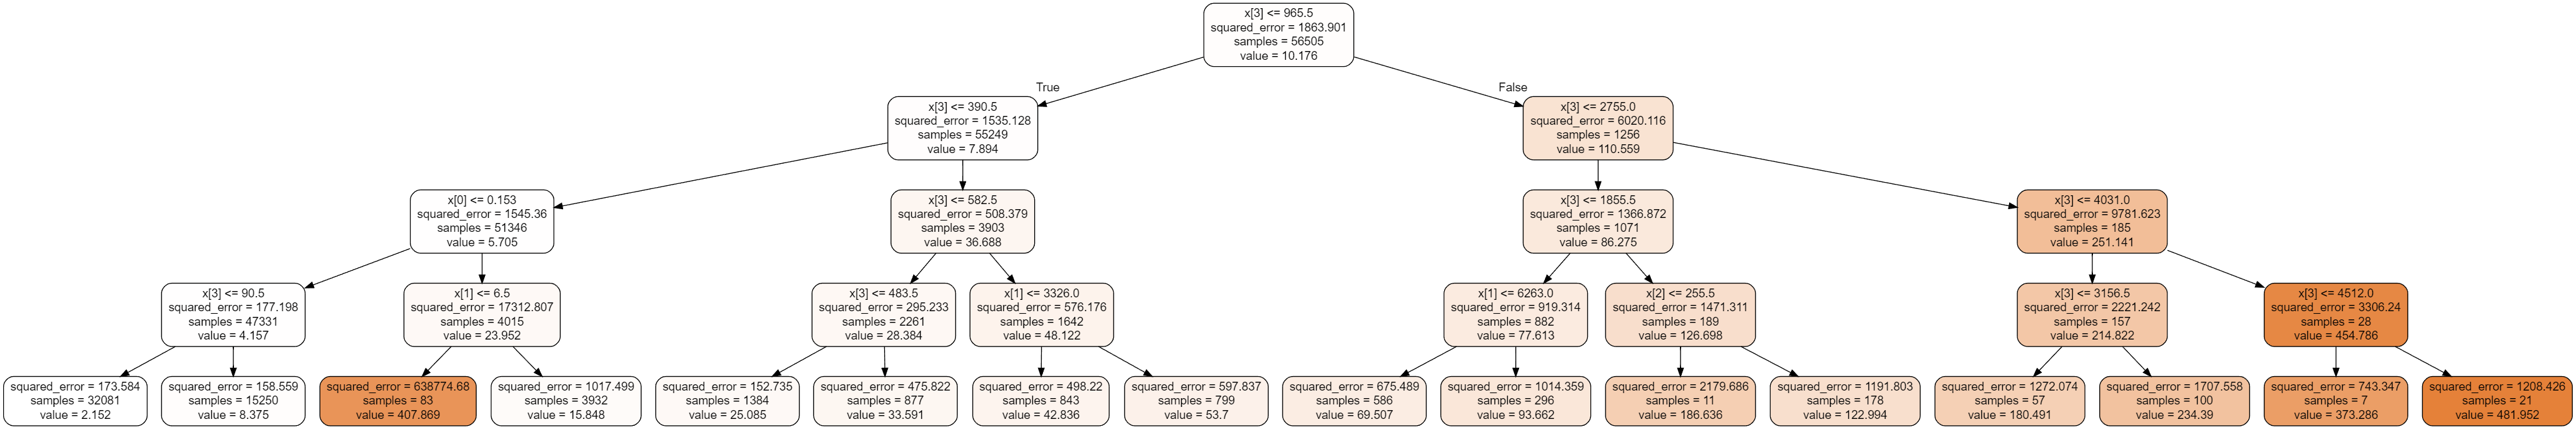

In [20]:
# Create image of decision tree 
from sklearn.tree import export_graphviz
import graphviz
# Save image
export_graphviz(covid_model, out_file='tree.dot', filled=True, rounded=True)
# Display image
from IPython.display import Image
Image(r"C:\Users\alane\Downloads\graphviz (1).png")

In [21]:
print("FOR REFERENCE: SELECTED VARIABLES IN MODEL WITH RESPECTIVE INDICES\n")
for idvar, var in enumerate(selected_vars): 
    print(idvar, var)

FOR REFERENCE: SELECTED VARIABLES IN MODEL WITH RESPECTIVE INDICES

0 percent_of_inpatients_with_covid
1 total_adult_patients_hospitalized_confirmed_and_suspected_covid
2 previous_day_admission_adult_covid_suspected
3 staffed_icu_adult_patients_confirmed_covid
4 previous_week_therapeutic_a_casirivimab_imdevimab_courses_used
5 previous_day_admission_adult_covid_confirmed
6 on_hand_supply_therapeutic_b_bamlanivimab_courses


### Try selected variables but with greater max depth
- Increasing the max depth of the decision tree does indeed decrease the MAE to 4.8 (percent error 0.21%)
- But, it is difficult to analyze the resulting tree by visualizing it since the tree is so large
- The difference between the shallow and deep decision trees is minimal, so will go on to a random forest for further investigation.

In [22]:
# split mean_imputed data
X = mean_imputed_df[selected_vars]
y = mean_imputed_df.deaths_covid

from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

# Create decision tree model
from sklearn.tree import DecisionTreeRegressor
covid_model_3 = DecisionTreeRegressor(max_depth = 50, random_state = 0)
covid_model_3.fit(train_X, train_y)

# Generate predictions 
val_predictions_3 = covid_model_3.predict(val_X)
# Inspect predictions and actual values from validation data
print("Predictions from val data:");print(val_predictions_3[:5])
print("Actual values from val data:");print(val_y.head())

# Calculate mean absolute error
from sklearn.metrics import mean_absolute_error
print("MAE: ", mean_absolute_error(val_y, val_predictions_3))

# calculate percent error of predictions
percent_error = mean_absolute_error(val_y, val_predictions_3) / (mean_imputed_df['deaths_covid'].max() - mean_imputed_df['deaths_covid'].min()) * 100
print("Percent error: ", percent_error)

# Create image of decision tree 
from sklearn.tree import export_graphviz
import graphviz
# Save image
export_graphviz(covid_model_3, out_file='tree3.dot', filled=True, rounded=True)

Predictions from val data:
[43.  0.  5.  0.  1.]
Actual values from val data:
46406    26.0
37822     0.0
16703    32.0
46483     0.0
4239      1.0
Name: deaths_covid, dtype: float64
MAE:  4.777944976342486
Percent error:  0.21225877282729835


## Random Forest
- Try a random forest model to see how performance improves
- If performance improves, use feature importance to inform further investigation

In [23]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Split mean_imputed data
X = mean_imputed_df[selected_vars]
y = mean_imputed_df.deaths_covid
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

print(f"Shape of train_X: {train_X.shape}")  # Debugging statement

# Train a random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_X, train_y)  

# Generate predictions 
val_predictions_4 = rf_model.predict(val_X)
from sklearn.metrics import mean_absolute_error
print("MAE: ", mean_absolute_error(val_y, val_predictions_4))
percent_error = mean_absolute_error(val_y, val_predictions_4) / (mean_imputed_df['deaths_covid'].max() - mean_imputed_df['deaths_covid'].min()) * 100
print("Percent error: ", percent_error)

# Calculate feature importances
feature_importances = rf_model.feature_importances_
for feature, importance in enumerate(feature_importances) :
    print("Feature", feature, "importance: ", importance)


Shape of train_X: (56505, 7)
MAE:  3.8633754255997834
Percent error:  0.1716292947845306
Feature 0 importance:  0.2841904792294698
Feature 1 importance:  0.2799121043713583
Feature 2 importance:  0.12497739435197873
Feature 3 importance:  0.2728492862752046
Feature 4 importance:  0.0068494251655962
Feature 5 importance:  0.024404366399134302
Feature 6 importance:  0.006816944207258049


### Generate Partial Dependence Plots for Variables with highest feature importance
- Features 0, 1, and 3 were found to have the highest feature importance
- Use partial dependence plot to identify any potential interaction effects between these features that may be the cause of unalignment between aggregate scores and Covid deaths.
- Observe that each of the three plot has a spike in their upper limits. This could be a potential interaction(s) between the three variables

Processing feature 0
Processing feature 1
Processing feature 3


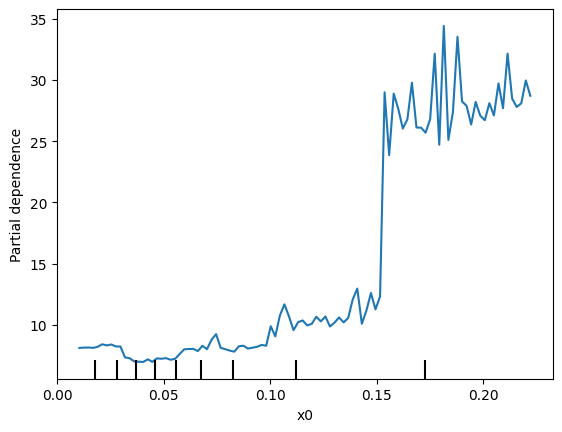

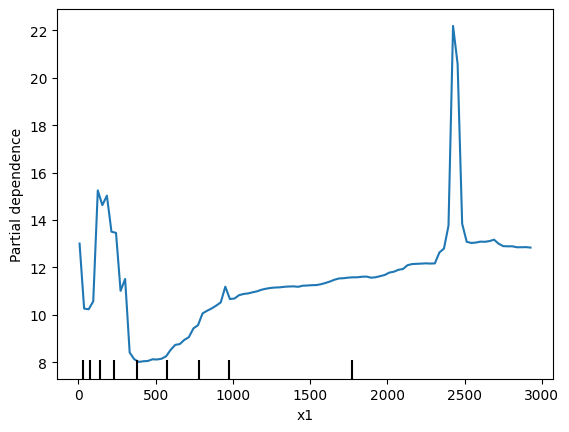

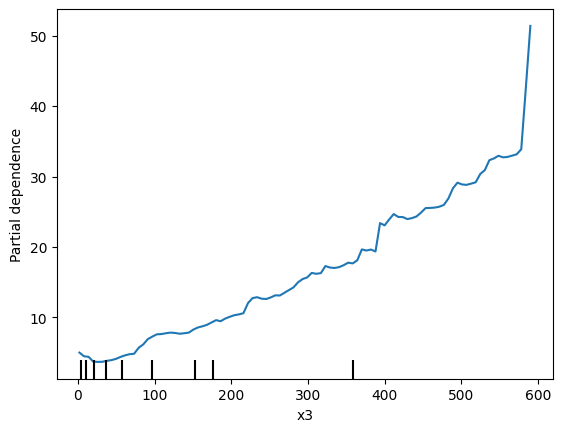

<Figure size 640x480 with 0 Axes>

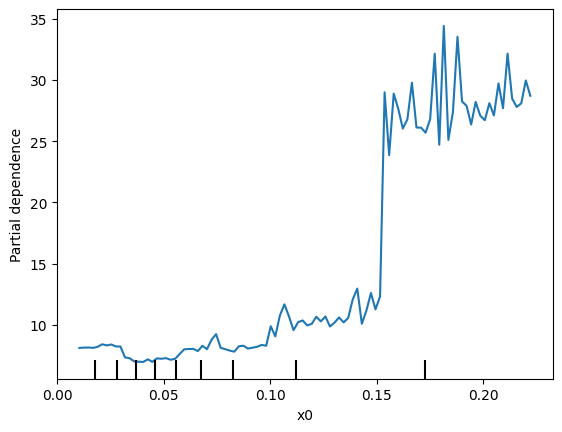

<Figure size 640x480 with 0 Axes>

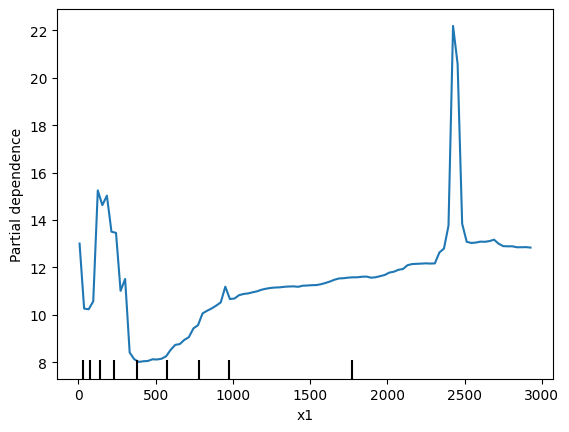

<Figure size 640x480 with 0 Axes>

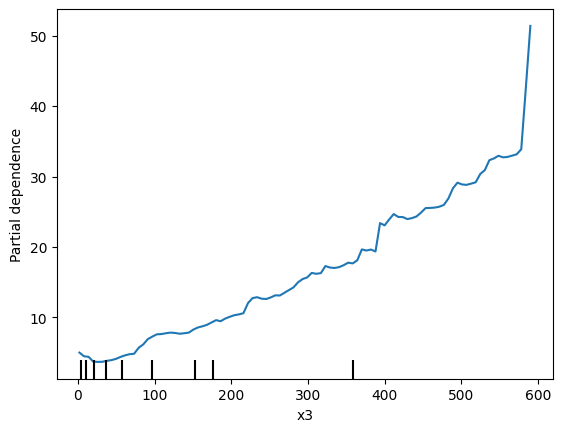

In [25]:
import numpy as np
from sklearn.inspection import PartialDependenceDisplay

# Convert DataFrame to NumPy array
X_array = X.to_numpy()

# Clear existing plots
plt.close('all')

# list of feature indices to plot
feature_indices_to_plot = [0, 1, 3]

# create a list to store display objects
display_objects = []
# Iterate over each feature index and create partial dependence plots
for feature_index in feature_indices_to_plot:
    print("Processing feature", feature_index)
    
    # Extract the feature column from the NumPy array
    feature_column = X_array[:, feature_index]
    
    # Create PartialDependenceDisplay object for the current feature
    display = PartialDependenceDisplay.from_estimator(
        estimator=rf_model, X=X_array, features=[feature_index]
    )
    # Append the display object to the list
    display_objects.append(display)

    plt.savefig('plot.pdf')
# Plot all partial dependence plots
for i, display in enumerate(display_objects):
    plt.figure()
    display.plot()
    plt.savefig(f'plot_feature_{feature_indices_to_plot[i]}.png')  # Save the plot to a PDF file
    plt.close




### Fit OLS regression model with Interaction Term
- Find if a statistically-significant interaction exists between any of the 3 high-imprtance features.
- Estimate effect size
- Results: all interaction effects are statistically-significant per their p-values, but the interaction coefficient (representing size) between the variables "total adult patients hospitalized confirmed and suspected covid" and "staffed icu adult patients confirmed covid" is by far the largest (2.852).

In [26]:
#
## OLS Analysis to determine significance and size of potential interaction effect between features 1 and 3
#

import statsmodels.api as sm

# Fit regression model with interaction term
X_interact = sm.add_constant(X)  # Assuming X contains both predictors
X_interact['interaction'] = X['total_adult_patients_hospitalized_confirmed_and_suspected_covid'] * X['staffed_icu_adult_patients_confirmed_covid']  # Create interaction term
model = sm.OLS(y, X_interact)
results = model.fit()

# Examine interaction coefficient and p-value
interaction_coefficient = results.params['interaction']
interaction_p_value = results.pvalues['interaction']

# Check significance
if interaction_p_value < 0.05:
    print("Interaction between Feature 1 and Feature 3 is significant.")
else:
    print("No significant interaction between Feature 1 and Feature 3.")
print("interaction p value:", interaction_p_value)
print("interaction coefficient:", interaction_coefficient)

Interaction between Feature 1 and Feature 3 is significant.
interaction p value: 1.0816879733688918e-264
interaction coefficient: 2.8522452819575295e-06


In [27]:
#
## OLS Analysis to determine significance and size of potential interaction effect between features 0 and 1
#

import statsmodels.api as sm

# Fit regression model with interaction term
X_interact = sm.add_constant(X)  # Assuming X contains both predictors
X_interact['interaction'] = X['percent_of_inpatients_with_covid'] * X['total_adult_patients_hospitalized_confirmed_and_suspected_covid']  # Create interaction term
model = sm.OLS(y, X_interact)
results = model.fit()

# Examine interaction coefficient and p-value
interaction_coefficient = results.params['interaction']
interaction_p_value = results.pvalues['interaction']

# Check significance
if interaction_p_value < 0.05:
    print("Interaction between Feature 0 and Feature 1 is significant.")
else:
    print("No significant interaction between Feature 0 and Feature 1.")
print("interaction p value:", interaction_p_value)
print("interaction coefficient:", interaction_coefficient)

Interaction between Feature 0 and Feature 1 is significant.
interaction p value: 9.245131842016863e-167
interaction coefficient: 0.02937525720679863


In [28]:
#
## OLS Analysis to determine significance and size of potential interaction effect between features 0 and 3
#

import statsmodels.api as sm

# Fit regression model with interaction term
X_interact = sm.add_constant(X)  # Assuming X contains both predictors
X_interact['interaction'] = X['percent_of_inpatients_with_covid'] * X['staffed_icu_adult_patients_confirmed_covid']  # Create interaction term
model = sm.OLS(y, X_interact)
results = model.fit()

# Examine interaction coefficient and p-value
interaction_coefficient = results.params['interaction']
interaction_p_value = results.pvalues['interaction']

# Check significance
if interaction_p_value < 0.05:
    print("Interaction between Feature 0 and Feature 3 is significant.")
else:
    print("No significant interaction between Feature 0 and Feature 3.")
print("interaction p value:", interaction_p_value)
print("interaction coefficient:", interaction_coefficient)

Interaction between Feature 0 and Feature 3 is significant.
interaction p value: 6.658478755899085e-199
interaction coefficient: 0.15385798179760243


### Add Interaction term from OLS Analysis to Random Forest to see effect on performance
- Adding the interaction term to the Random Forest model actually yielded a more poorly-performing model (MAE 4.01)
- Suggests that the interaction effect identified by the OLS analysis may not be effectively captured in decision-making
- Could be that I need to tinker with hyperparameters more.

In [31]:
# Create interaction term (same as before)
X_interact['interaction'] = X['total_adult_patients_hospitalized_confirmed_and_suspected_covid'] * X['staffed_icu_adult_patients_confirmed_covid']
# split mean_imputed data with interaction term
X_train_interact, X_val_interact, y_train, y_val = train_test_split(X_interact, y, random_state=42)
# Initialize and train the random forest regressor
rf_model_with_interactions = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_with_interactions.fit(X_train_interact, y_train)
# Generate predictions 
val_predictions = rf_model_with_interactions.predict(X_val_interact)
# Calculate mean absolute error
from sklearn.metrics import mean_absolute_error
print("MAE: ", mean_absolute_error(y_val, val_predictions))

# calculate percent error of predictions
percent_error = mean_absolute_error(val_y, val_predictions) / (mean_imputed_df['deaths_covid'].max() - mean_imputed_df['deaths_covid'].min()) * 100
print("Percent error: ", percent_error)


MAE:  4.0143532908833715
Percent error:  0.6718606621756216


## Discussion
While the interaction effect-incorporated random forest did not corroborate what the OLS analysis suggested (that "total adult patients hospitalized confirmed and suspected covid" and "staffed icu adult patients confirmed covid" were exhibiting an important interaction), I do think it's worth trying to interpret the relationship between these two variables. After all, the random forest model is complex and, if not expertly-tuned, is liable to all sorts of issues with overfitting and noise that could lead to the poorer performance.<br>
Assuming that the interaction effect between "total adult patients hospitalized confirmed and suspected covid" and "staffed icu adult patients confirmed covid" is important, and try to understand the relationship between these two variables. While they appear to have some overlap and redundancy, they may also capture distinct aspects of the Covid patient populations and how they affect hospitals' responses to an uptick in Covid patients. Relying on the idea that these two variables, representing hospitalized and ICU admitted patients with Covid, respectively, indeed tell us different things, I gathered my thoughts on the potential underlying mechanism of this interaction:
- It could mean that when more adults with Covid end up in the ICU, the hospitalized COVID patients treated elsewhere in the hospital have an increased chance of dying.
- This may not only suggest the given fact that it's important to make sure we have enough ICU beds and resources, but also that if we focus too much on the ICU, it might mean that other hospitalized patients don't get the care they need, which could also lead to more COVID deaths overall.
- It's plausible that the allocation of hospital staff and resources to the ICU, spurred by increased severe Covid cases, could lead to decreased efforts afforded to prevent hospitalized patients with Covid from progressing to critical states and succumbing.


## Conclusion
This analysis has identified a potential interaction effect between the number of ICU patients with Covid and the number of adult hospitalized patients who may have Covid, resulting in greater Covid deaths in hospitals. I provided my thoughts about the mechanism of and implications of this interaction, but I drew no conclusions or actionable insights for reducing Covid deaths in hospitals. <br>A machine learning model, perhaps a Random Forest regressor like the one used here, could be further adjusted to corroborate the interaction effect suggested by the OLS analysis. <br> Additionally, a deeper investigation into the temporal patterns of the data could better illuminate the mechanism of the identified interaction effect and any others. More information on the flow of patients could be helpful in this respect as well: how many of the ICU patients were admitted directly upon arrival, how many were transferred from elsewhere in the hospital, and how many exhibited Covid symptoms only after entering the ICU? This data could help us understand whether the identified interaction effect occurs due more to issues with quarantining in hospitals, rather than with allocation of treatment resources

## References
COVID HOSPITAL DATA FROM US DEPT OF HEALTH AND HUMAN SERVICES: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh/about_data <br> POPULATION DATA FROM US CENSUS: https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html <br> STATE CODE REFERENCES: https://worldpopulationreview.com/states/state-abbreviations 